In [1]:
%cd ..

/app


In [1]:
import numpy as np
from tqdm import tqdm

from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step
from tensoraerospace.agent.ihdp.model import IHDPAgent
from tensoraerospace.benchmark import ControlBenchmark

In [2]:
dt = 0.01  # Дискретизация
tp = generate_time_period(tn=20, dt=dt) # Временной период
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp) # Количество временных шагов
reference_signals = np.reshape(unit_step(degree=5, tp=tp, time_step=10, output_rad=True), [1, -1]) # Заданный сигнал

In [3]:
import gymnasium as gym 
env = gym.make('LinearLongitudinalF16-v0',
               number_time_steps=number_time_steps, 
               initial_state=[[0],[0],[0],[0]],
               reference_signal = reference_signals,
              tracking_states=["alpha"])
env.reset()

(array([[0.],
        [0.]]),
 {})

In [4]:
actor_settings = {
    "start_training": 5,
    "layers": (25, 1), 
    "activations":  ('tanh', 'tanh'), 
    "learning_rate": 2, 
    "learning_rate_exponent_limit": 10,
    "type_PE": "combined",
    "amplitude_3211": 15, 
    "pulse_length_3211": 5/dt, 
    "maximum_input": 25,
    "maximum_q_rate": 20,
    "WB_limits": 30,
    "NN_initial": 120,
    "cascade_actor": False,
    "learning_rate_cascaded":1.2
}

In [5]:
incremental_settings = {
    "number_time_steps": number_time_steps, 
    "dt": dt, 
    "input_magnitude_limits":25, 
    "input_rate_limits":60,
}

In [6]:
critic_settings = {
    "Q_weights": [8], 
    "start_training": -1, 
    "gamma": 0.99, 
    "learning_rate": 15, 
    "learning_rate_exponent_limit": 10,
    "layers": (25,1), 
    "activations": ("tanh", "linear"), 
        "WB_limits": 30,
    "NN_initial": 120,
    "indices_tracking_states": env.unwrapped.indices_tracking_states
}

In [7]:
model = IHDPAgent(actor_settings, critic_settings, incremental_settings, env.unwrapped.tracking_states, env.unwrapped.state_space, env.unwrapped.control_space, number_time_steps, env.unwrapped.indices_tracking_states)

In [8]:
xt = np.array([[np.deg2rad(3)], [0]])

for step in tqdm(range(number_time_steps-2)):
    ut = model.predict(xt, reference_signals, step)
    xt, reward, terminated, truncated, info = env.step(np.array(ut))

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:246: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(
100%|██████████| 2000/2000 [00:19<00:00, 104.78it/s]


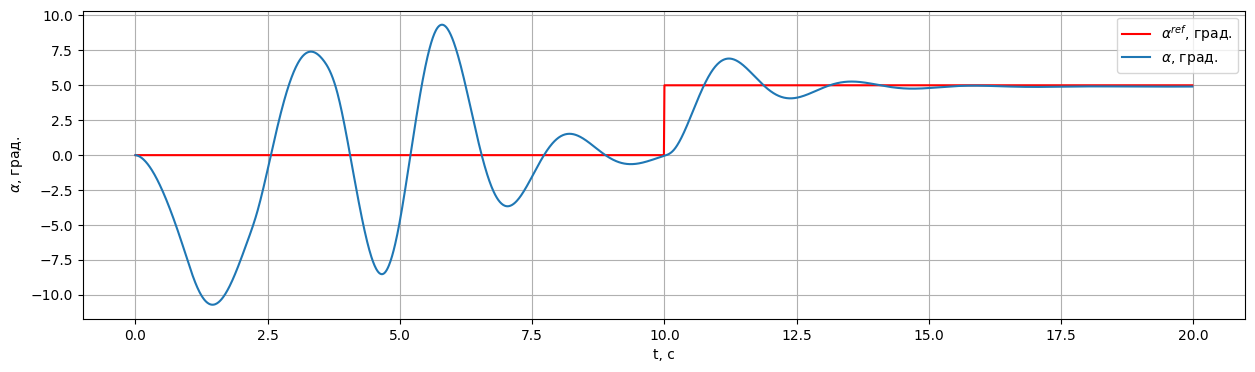

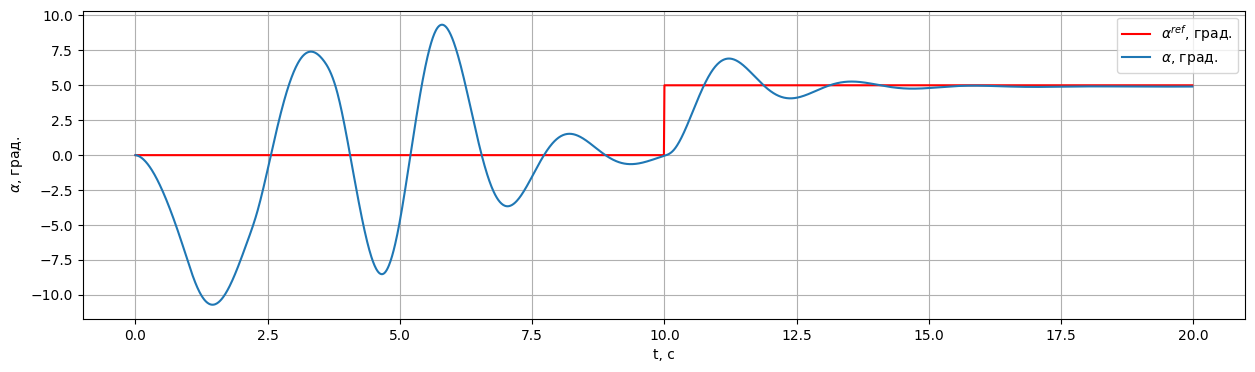

In [9]:
env.unwrapped.model.plot_transient_process('alpha', tps, reference_signals[0], to_deg=True, figsize=(15,4))

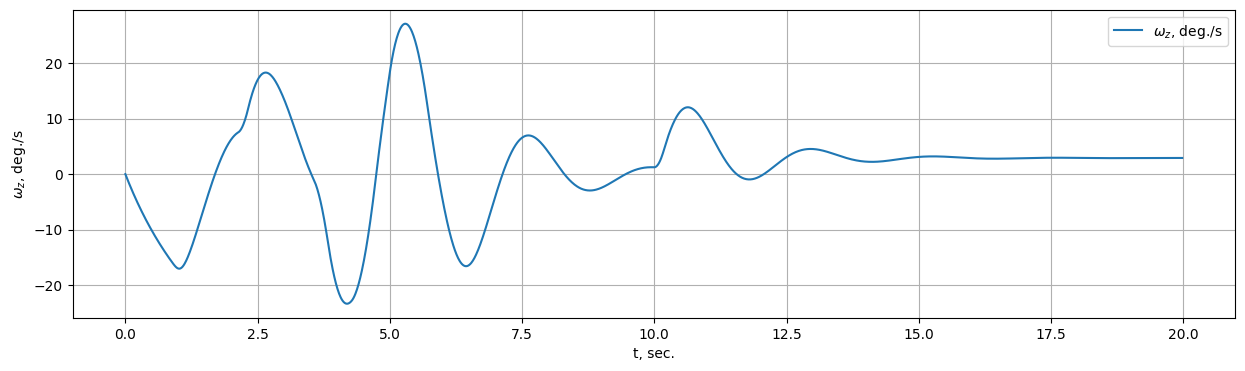

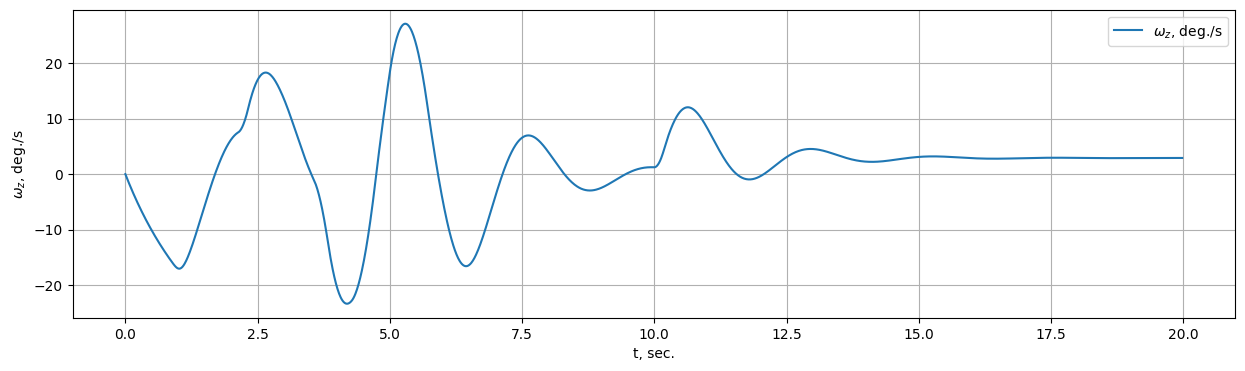

In [14]:
env.unwrapped.model.plot_state(state_name='wz', time=tps, to_deg=True, figsize=(15,4))

### Оцениваем переходнный процесс

In [9]:
system_signal_orig = env.unwrapped.model.get_state('alpha', to_deg=True)[:2000]
control_signal_orig = np.rad2deg(reference_signals[0])[:2000]

In [10]:
bench = ControlBenchmark()

In [11]:
res = bench.becnchmarking_one_step(control_signal_orig, system_signal_orig, 1, dt)

In [12]:
print("Статическая ошибка: ", res['static_error'])
print("Время переходного процесса: ", res['settling_time'], "сек")
print("Степень затухания: ", res['damping_degree'])
print("Перерегулирование: ", res['overshoot'])

Статическая ошибка:  0.09364396939733588
Время переходного процесса:  3.65 сек
Степень затухания:  0.10147463339336926
Перерегулирование:  38.25950355288255


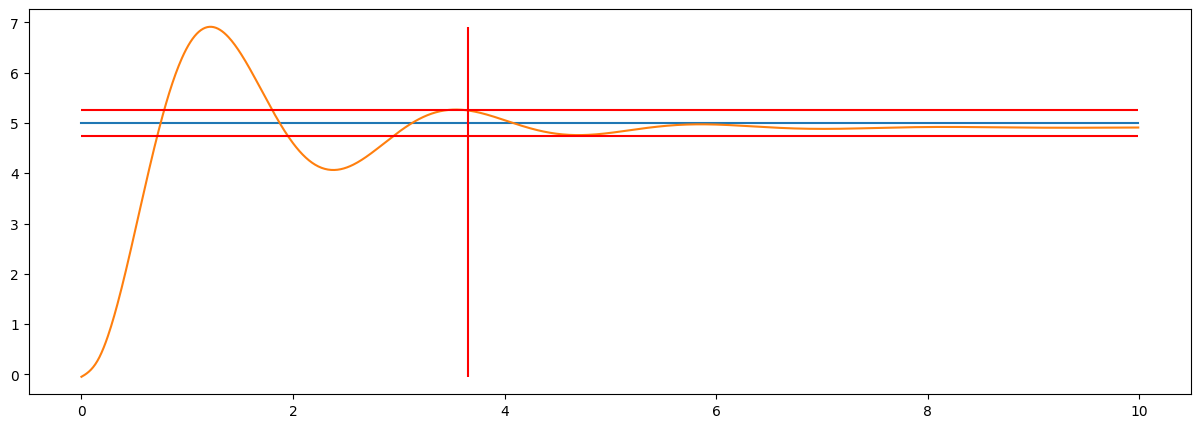

In [13]:
bench.plot(control_signal_orig, system_signal_orig, 1, dt, tps, figsize=(15,5))